In [4]:
cd ../..

/Users/hao/workspace/hpi_de/4th_Semester/Applied Machine Learning/sensor-data-gans


In [5]:
import numpy as np
import pandas as pd
import tensorflow
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from utils.windowing import windowing_dataframe, transform_windows_df

## Read Data

In [6]:
train_df = pd.read_hdf('./datasets/mydata/train_df.h5')
val_df = pd.read_hdf('./datasets/mydata/val_df.h5')
test_df = pd.read_hdf('./datasets/mydata/test_df.h5')

## Windowing Timeseries Data

In [7]:
window_size = 5*50
step_size = int(window_size/2)
col_names = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z', 'userAcceleration.c']
method ='sliding'
labels=["standing", "walking", "jogging"]

In [8]:
train_windowed_df = windowing_dataframe(train_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)
val_windowed_df = windowing_dataframe(val_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)
test_windowed_df = windowing_dataframe(test_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)

## Classifiers

### SVM

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
input_cols = ['userAcceleration.c']
x_train, y_train = transform_windows_df(train_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_val, y_val = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_test, y_test = transform_windows_df(test_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)

In [11]:
x_train = np.concatenate([x_train, x_val])
y_train = np.concatenate([y_train, y_val])

In [12]:
x_train = x_train.reshape((len(x_train), window_size))
x_val = x_val.reshape((len(x_val), window_size))
x_test = x_test.reshape((len(x_test), window_size))

In [13]:
svm_clf = SVC()
svm_clf.fit(x_train, y_train)
# svm_clf.fit(x_val, y_val)

SVC()

#### train performance

In [14]:
y_train_head = svm_clf.predict(x_train)
# y_train_head = svm_clf.predict(x_val)

In [15]:
print(classification_report(y_train, y_train_head, target_names=labels))

              precision    recall  f1-score   support

    standing       0.62      1.00      0.77      1977
     walking       0.87      0.46      0.61      2256
     jogging       1.00      0.82      0.90       829

    accuracy                           0.73      5062
   macro avg       0.83      0.76      0.76      5062
weighted avg       0.80      0.73      0.72      5062



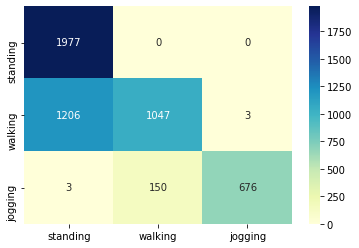

In [16]:
cm = confusion_matrix(y_train, y_train_head)
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

#### test performance

In [17]:
y_test_head = svm_clf.predict(x_test)

In [18]:
print(classification_report(y_test, y_test_head, target_names=labels))

              precision    recall  f1-score   support

    standing       0.69      1.00      0.82       403
     walking       0.78      0.35      0.49       387
     jogging       0.67      0.78      0.72       173

    accuracy                           0.70       963
   macro avg       0.71      0.71      0.67       963
weighted avg       0.72      0.70      0.67       963



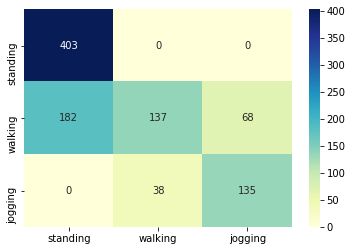

In [19]:
cm = confusion_matrix(y_test, y_test_head)
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

### CNN

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPool1D, GlobalMaxPool1D, Flatten, Dropout
from sklearn.metrics import classification_report

In [21]:
input_cols = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
x_train, y_train = transform_windows_df(train_windowed_df, input_cols=input_cols, one_hot_encode=True, as_channel=False)
x_val, y_val = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=True, as_channel=False)
x_test, y_test = transform_windows_df(test_windowed_df, input_cols=input_cols, one_hot_encode=True, as_channel=False)

In [22]:
input_shape = x_train[0].shape

### build neural net

In [23]:
model = Sequential()
model.add(Conv1D(8, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 246, 8)            128       
_________________________________________________________________
flatten (Flatten)            (None, 1968)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 5907      
Total params: 6,035
Trainable params: 6,035
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
# x, y = shuffle(x_train, y_train)
x, y = shuffle(x_val, y_val)
model.fit(x, y, batch_size=32, epochs=10)#, validation_data=(x_val, y_val))

Epoch 1/10
33/33 [==============================] - 0s 2ms/step - loss: 0.8345 - accuracy: 0.5222
Epoch 2/10
33/33 [==============================] - 0s 2ms/step - loss: 0.6349 - accuracy: 0.7886
Epoch 3/10
33/33 [==============================] - 0s 2ms/step - loss: 0.3961 - accuracy: 0.9662
Epoch 4/10
33/33 [==============================] - 0s 2ms/step - loss: 0.1547 - accuracy: 0.9855
Epoch 5/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0749 - accuracy: 0.9952
Epoch 6/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0487 - accuracy: 0.9961
Epoch 7/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.9981
Epoch 8/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.9981
Epoch 9/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9981
Epoch 10/10
33/33 [==============================] - 0s 2ms/step - loss: 0.0180 - accuracy: 0.9981


#### training performance

In [26]:
model.evaluate(x, y)

33/33 [==============================] - 0s 964us/step - loss: 0.0164 - accuracy: 0.9990


[0.01636635884642601, 0.9990347623825073]

In [27]:
y_head = model.predict(x)

In [28]:
print(classification_report(y.argmax(axis=-1), y_head.argmax(axis=-1), target_names=labels))

              precision    recall  f1-score   support

    standing       1.00      1.00      1.00       430
     walking       1.00      1.00      1.00       446
     jogging       1.00      0.99      1.00       160

    accuracy                           1.00      1036
   macro avg       1.00      1.00      1.00      1036
weighted avg       1.00      1.00      1.00      1036



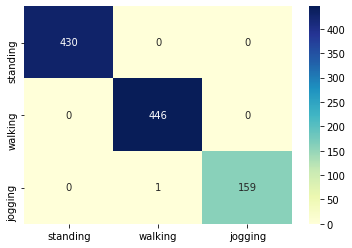

In [29]:
cm = confusion_matrix(y.argmax(axis=-1), y_head.argmax(axis=-1))
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

#### test performance

In [30]:
model.evaluate(x_test, y_test)

31/31 [==============================] - 0s 813us/step - loss: 0.1345 - accuracy: 0.9626


[0.1345376968383789, 0.9626168012619019]

In [31]:
y_head = model.predict(x_test)

In [32]:
print(classification_report(y_test.argmax(axis=-1), y_head.argmax(axis=-1), target_names=labels))

              precision    recall  f1-score   support

    standing       1.00      1.00      1.00       403
     walking       0.98      0.93      0.95       387
     jogging       0.86      0.95      0.90       173

    accuracy                           0.96       963
   macro avg       0.95      0.96      0.95       963
weighted avg       0.96      0.96      0.96       963



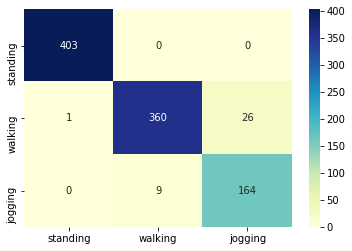

In [33]:
cm = confusion_matrix(y_test.argmax(axis=-1), y_head.argmax(axis=-1))
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

### LSTM

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, Flatten, Dropout
from sklearn.metrics import classification_report

In [35]:
input_cols = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
x_train, y_train = transform_windows_df(train_windowed_df, input_cols=input_cols, one_hot_encode=True, as_channel=False)
x_val, y_val = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=True, as_channel=False)
x_test, y_test = transform_windows_df(test_windowed_df, input_cols=input_cols, one_hot_encode=True, as_channel=False)

In [36]:
input_shape = x_train[0].shape

In [37]:
model = Sequential()
model.add(LSTM(8, return_sequences=True, input_shape=input_shape))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 250, 8)            384       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6003      
Total params: 6,387
Trainable params: 6,387
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
x, y = shuffle(x_train, y_train)
#x, y = shuffle(x_val, y_val)
model.fit(x, y, batch_size=32, epochs=10)#, validation_data=(x_val, y_val))

Epoch 1/10
126/126 [==============================] - 6s 45ms/step - loss: 0.5175 - accuracy: 0.8279
Epoch 2/10
126/126 [==============================] - 5s 43ms/step - loss: 0.1025 - accuracy: 0.9707
Epoch 3/10
126/126 [==============================] - 5s 42ms/step - loss: 0.0383 - accuracy: 0.9911
Epoch 4/10
126/126 [==============================] - 5s 42ms/step - loss: 0.0267 - accuracy: 0.9935
Epoch 5/10
126/126 [==============================] - 5s 43ms/step - loss: 0.0219 - accuracy: 0.9928
Epoch 6/10
126/126 [==============================] - 5s 43ms/step - loss: 0.0164 - accuracy: 0.9955
Epoch 7/10
126/126 [==============================] - 5s 43ms/step - loss: 0.0152 - accuracy: 0.9963
Epoch 8/10
126/126 [==============================] - 5s 43ms/step - loss: 0.0110 - accuracy: 0.9973
Epoch 9/10
126/126 [==============================] - 6s 45ms/step - loss: 0.0083 - accuracy: 0.9970
Epoch 10/10
126/126 [==============================] - 6s 45ms/step - loss: 0.0059 - accura

#### training performance

In [40]:
model.evaluate(x, y)

126/126 [==============================] - 1s 9ms/step - loss: 0.0051 - accuracy: 0.9993


[0.00510386424139142, 0.9992548227310181]

In [41]:
y_head = model.predict(x)

In [42]:
print(classification_report(y.argmax(axis=-1), y_head.argmax(axis=-1), target_names=labels))

              precision    recall  f1-score   support

    standing       1.00      1.00      1.00      1547
     walking       1.00      1.00      1.00      1810
     jogging       1.00      1.00      1.00       669

    accuracy                           1.00      4026
   macro avg       1.00      1.00      1.00      4026
weighted avg       1.00      1.00      1.00      4026



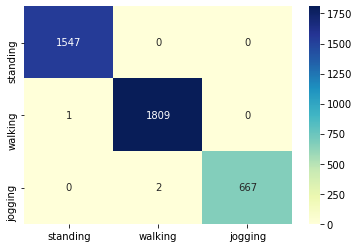

In [43]:
cm = confusion_matrix(y.argmax(axis=-1), y_head.argmax(axis=-1))
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

#### test performance

In [44]:
model.evaluate(x_test, y_test)

31/31 [==============================] - 0s 9ms/step - loss: 0.0158 - accuracy: 0.9969


[0.015831271186470985, 0.9968847632408142]

In [45]:
y_head = model.predict(x_test)

In [46]:
print(classification_report(y_test.argmax(axis=-1), y_head.argmax(axis=-1), target_names=labels))

              precision    recall  f1-score   support

    standing       1.00      1.00      1.00       403
     walking       0.99      1.00      1.00       387
     jogging       1.00      0.98      0.99       173

    accuracy                           1.00       963
   macro avg       1.00      0.99      1.00       963
weighted avg       1.00      1.00      1.00       963



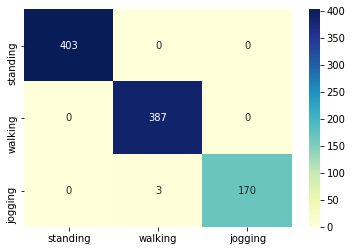

In [47]:
cm = confusion_matrix(y_test.argmax(axis=-1), y_head.argmax(axis=-1))
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

### BiLSTM

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, Flatten, Dropout
from sklearn.metrics import classification_report

In [49]:
input_cols = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
x_train, y_train = transform_windows_df(train_windowed_df, input_cols=input_cols, one_hot_encode=True, as_channel=False)
x_val, y_val = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=True, as_channel=False)
x_test, y_test = transform_windows_df(test_windowed_df, input_cols=input_cols, one_hot_encode=True, as_channel=False)

In [50]:
input_shape = x_train[0].shape

In [51]:
model = Sequential()
model.add(Bidirectional(LSTM(8, return_sequences=True), input_shape=input_shape))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 250, 16)           768       
_________________________________________________________________
flatten_2 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12003     
Total params: 12,771
Trainable params: 12,771
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
x, y = shuffle(x_train, y_train)
model.fit(x, y, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
126/126 [==============================] - 10s 78ms/step - loss: 0.3362 - accuracy: 0.8825 - val_loss: 0.0450 - val_accuracy: 0.9942
Epoch 2/10
126/126 [==============================] - 9s 73ms/step - loss: 0.0299 - accuracy: 0.9921 - val_loss: 0.0428 - val_accuracy: 0.9952
Epoch 3/10
126/126 [==============================] - 9s 71ms/step - loss: 0.0253 - accuracy: 0.9933 - val_loss: 0.0425 - val_accuracy: 0.9952
Epoch 4/10
126/126 [==============================] - 9s 70ms/step - loss: 0.0145 - accuracy: 0.9963 - val_loss: 0.0392 - val_accuracy: 0.9971
Epoch 5/10
126/126 [==============================] - 9s 73ms/step - loss: 0.0145 - accuracy: 0.9970 - val_loss: 0.0476 - val_accuracy: 0.9961
Epoch 6/10
126/126 [==============================] - 11s 85ms/step - loss: 0.0089 - accuracy: 0.9980 - val_loss: 0.0495 - val_accuracy: 0.9952
Epoch 7/10
126/126 [==============================] - 9s 74ms/step - loss: 0.0066 - accuracy: 0.9985 - val_loss: 0.0467 - val_accuracy: 0.99

#### training performance

In [54]:
model.evaluate(x, y)

126/126 [==============================] - 2s 12ms/step - loss: 0.0019 - accuracy: 0.9993


[0.0018691375153139234, 0.9992548227310181]

In [55]:
y_head = model.predict(x)

In [56]:
print(classification_report(y.argmax(axis=-1), y_head.argmax(axis=-1), target_names=labels))

              precision    recall  f1-score   support

    standing       1.00      1.00      1.00      1547
     walking       1.00      1.00      1.00      1810
     jogging       1.00      1.00      1.00       669

    accuracy                           1.00      4026
   macro avg       1.00      1.00      1.00      4026
weighted avg       1.00      1.00      1.00      4026



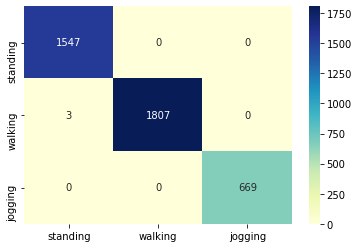

In [57]:
cm = confusion_matrix(y.argmax(axis=-1), y_head.argmax(axis=-1))
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

#### test performance

In [58]:
model.evaluate(x_test, y_test)

31/31 [==============================] - 0s 12ms/step - loss: 0.4195 - accuracy: 0.9574


[0.41948333382606506, 0.9574247002601624]

In [59]:
y_head = model.predict(x_test)

In [60]:
print(classification_report(y_test.argmax(axis=-1), y_head.argmax(axis=-1), target_names=labels))

              precision    recall  f1-score   support

    standing       1.00      1.00      1.00       403
     walking       1.00      0.90      0.94       387
     jogging       0.81      0.99      0.89       173

    accuracy                           0.96       963
   macro avg       0.94      0.96      0.95       963
weighted avg       0.96      0.96      0.96       963



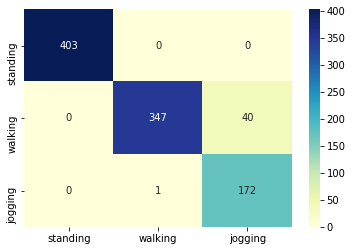

In [61]:
cm = confusion_matrix(y_test.argmax(axis=-1), y_head.argmax(axis=-1))
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')